In [1]:
from __future__ import division
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
%pylab inline

pylab.rcParams['figure.figsize'] = (16.0, 8.0) # Control figure size 
percentify = lambda x: (x * 100).round(1).astype(str) + "%"

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('facebook-fact-check.txt')

page_likes = {'ABC News Politics':712048, 'Addicting Info':1254536,
              'CNN Politics':2484115, 'Eagle Rising':681884,
              'Freedom Daily':1951544, 'Occupy Democrats':6199514,
              'Politico':1595952, 'Right Wing News':3585516,
              'The Other 98%':4758192}

possible_ratings = ["mostly false", "mixture of true and false", 
                    "mostly true", "no factual content"]

print list(data)
print data.shape

['account_id', 'post_id', 'Category', 'Page', 'Post URL', 'Date Published', 'Post Type', 'Rating', 'Debate', 'share_count', 'reaction_count', 'comment_count']
(2282, 12)


The Model

Map from an input vector to a probability of a rating.

The thing is, category and page aren't independent inputs, so can't we just use
page? Aw crap, that's only two.

P('mostly false'| page='Politico', type='link')

P('mostly false') = P(page='Politico' | 'mostly false') * P(type = 'link' | 'mostly false')

Compute for all truthfulness ratings, pick the highest rating.

Since it's such a simple dataset, we build our own implementation.

In [12]:
# Helper Functions

def RMSE(predictions, true_vals):
    """
    We want some way to measure the distance between predictions that 
    heavily penalizes marking true as false and false as true.
    
    d("no factual content", anything) = 1
    d(rating, rating) = 0
    d("mostly true/false", "mixture of true and false") = 1
    d("mostly true", "mostly false") = 2
    
    Then RMSE = sqrt( 1/n * sum( d(prediction_i, truth_i)**2 ) )
    """
    def d(x,y):
        if x == y:
            return 0
        elif x == 3 or y == 3:
            return 1
        elif abs(x-y) == 1:
            return 1
        else:
            return 2
        
    tot = 0
    for i in xrange(len(predictions)):
        tot += d(predictions[i], true_vals[i])**2
    return np.sqrt( tot/len(predictions) )


def conf_mat(predicted, true, title, filename):
    """
    Display the confusion matrix for the data given and give the error rate.
    
    Both predicted and true are numpy vectors of integers between 0 and 3
    """
    if len(predicted) != len(true):
        raise ValueError('Predictions and true values must be the same length')
        
    n = len(predicted)
    confusion_mat = np.zeros((4,4))
    for i in xrange(n):
        confusion_mat[predicted[i],true[i]] += 1
    
    ax = seaborn.heatmap(pd.DataFrame(confusion_mat),cmap='Spectral_r')
    ax.set_xlabel('True Rating',size=18)
    ax.set_ylabel('Predicted Rating',size=18)
    plt.title(title,size=20)
    plt.savefig(filename, dpi=300)
    plt.show()
    
    error_rate = (n - np.sum(np.diag(confusion_mat)))/n
    print "Overall Error Rate: ", error_rate*100, "%"

def test_split(data, n):
    """ 
    Return randomly chosen test_data, train_data from a Pandas DataFrame,
    where test_data contains n values.
    """
    all_inds = np.random.permutation(range(0,len(data)))
    return data.iloc[all_inds[:n]], data.iloc[all_inds[n:]], all_inds

def build_probs(data, cols):
    """
    Given the training data, build the lookup tables to use for Naive Bayes.
    
    cols is a list containing the names of the columns, which must be 
    categorical. Should work for both page and category.
    
    Return a dictionary where each column name gives you an array where
    A[i,j] is the probability of feature j given rating i
    """
    tables = []
    
    # For each feature
    for col_name in cols:
        
        # Initialize the desired array
        arr = np.zeros((4,len(np.unique(data[col_name]))))
        
        # For each possible feature in the column category
        for j in np.unique(data[col_name]):
            
            # Count the number of times each rating occurs for the feature
            arr[:,j] = np.bincount(data[data[col_name]==j]['Rating'],minlength=4)
        
        # Normalize and store
        arr =  arr / np.sum(arr,axis=1)[:, np.newaxis]
        #arr[arr == 0] = epsilon
        tables.append(arr)
        
    return tables

def sensitivity(predicted, true):
    """
    predicted: 1 if false
               0 if true
                        
    true: 0 if false
    
    Return the number of true false values predicted as false, over the number
    of true false values.
    """
    found = 0
    true_false = 0
    for i in xrange(len(predicted)):
        if true[i] == 0:
            true_false += 1
            
            if predicted[i] == 1:
                found += 1
                
    return found/true_false
    
def specificity(predicted, true):
    """
    predicted: 1 if false
               0 if true
                        
    true: 0 if false
    
    Return the number of true non-false values predicted as non-false, over the
    number of true non-false values.
    """
    found = 0
    true_vals = 0
    for i in xrange(len(predicted)):
        if true[i] != 0:
            true_vals += 1
            
            if predicted[i] == 0:
                found += 1
                
    return found/true_vals

In [4]:
# Replace categorical data with ints so as to use numpy arrays

categories = ['left','mainstream','right']
category_inds = {'left':0,'mainstream':1,'right':2}

pages = ['ABC News Politics', 'Addicting Info', 'CNN Politics', 'Eagle Rising',
         'Freedom Daily', 'Occupy Democrats', 'Politico', 'Right Wing News',
         'The Other 98%']
page_inds = {'ABC News Politics':0, 'Addicting Info':1, 'CNN Politics':2, 
             'Eagle Rising':3, 'Freedom Daily':4, 'Occupy Democrats':5,
             'Politico':6, 'Right Wing News':7, 'The Other 98%':8}

types = ['link','photo','text','video']
type_inds = {'link':0, 'photo':1, 'text':2, 'video':3}

ratings = ["mostly false", "mixture of true and false", 
           "mostly true", "no factual content"]
rating_inds = {'mostly false':0, 'mixture of true and false':1,
               'mostly true':2, 'no factual content':3}

data = data.replace({'Category': category_inds})
data = data.replace({'Page':page_inds})
data = data.replace({'Post Type':type_inds})
data = data.replace({'Rating':rating_inds})

#print data[['Category','Page','Post Type','Rating']]

In [5]:
# Partition the dataset into test and training data

n = 400 # Approximate 80/20 split
test_data, train_data, all_inds = test_split(data, n)
true_vals = np.array(test_data['Rating'])

In [6]:
# Get probability tables for Naive Bayes

page_probs, type_probs = build_probs(train_data, ['Page', 'Post Type'])
cat_probs, type_probs = build_probs(train_data, ['Category', 'Post Type'])

predict_page_probs = np.zeros((n,4))
predict_cat_probs = np.zeros((n,4))

# Estimate probability of each category for each test point
for i in xrange(n):
    test_pt = test_data.ix[all_inds[i]] # Get the test point
    
    for j in xrange(4): # For each truthfulness category
        
        page_ind = test_pt['Page'] # Get the feature indices
        cat_ind = test_pt['Category']
        type_ind = test_pt['Post Type']
        
        # P(C_i) = prod( P(A_j = v_j|C_i) )
        predict_page_probs[i,j] = page_probs[j,page_ind] * type_probs[j,type_ind]
        predict_cat_probs[i,j] = cat_probs[j,cat_ind] * type_probs[j,type_ind]

In [36]:
# Sensitivity and specificity testing

print "Everything is True:"
print "\tSensitivity:", sensitivity(np.zeros(400), true_vals)
print "\tSpecificity:", specificity(np.zeros(400), true_vals)

print "\nEverything is False:"
print "\tSensitivity:", sensitivity(np.ones(400), true_vals)
print "\tSpecificity:", specificity(np.ones(400), true_vals)

print "\nFalse if 'mostly false' is highest probability:"
prediction = np.argmax(predict_cat_probs, axis=1)
prediction[prediction != 0] = 2
prediction[prediction == 0] = 1
prediction[prediction == 2] = 0
print "\tSensitivity:", sensitivity(prediction, true_vals)
print "\tSpecificity:", specificity(prediction, true_vals)

print "\nFalse if 'mostly false' or 'mixture' is highest probability:"
prediction = np.argmax(predict_cat_probs, axis=1)
prediction[prediction == 0] = 1
prediction[prediction == 0] = 1
prediction[prediction != 1] = 0
print "\tSensitivity:", sensitivity(prediction, true_vals)
print "\tSpecificity:", specificity(prediction, true_vals)

print "\nFalse if 'mostly false' is top two highest probability:"
toptwo = np.argsort(predict_cat_probs, axis=1)[:,2:]
prediction = np.zeros(n)
for i in xrange(n):
    if 0 in toptwo[i]:
        prediction[i] = 1
    else:
        prediction[i] = 0
print "\tSensitivity:", sensitivity(prediction, true_vals)
print "\tSpecificity:", specificity(prediction, true_vals)

for threshold in [0.75, 0.5, 0.15, 0.05, 0.01]:
    print "\nFalse if probability of 'mostly false' is > ", threshold
    
    prediction = np.zeros(n)
    for i in xrange(n):
        if predict_cat_probs[i,0] > threshold:
            prediction[i] = 1
        else:
            prediction[i] = 0
    print "\tSensitivity:", sensitivity(prediction, true_vals)
    print "\tSpecificity:", specificity(prediction, true_vals)
    
for threshold in [0.5, 0.25, 0.01]:
    print "\nFalse if normalized probability of 'mostly false' is > ", threshold
    
    prediction = np.zeros(n)
    for i in xrange(n):
        if predict_cat_probs[i,0]/np.sum(predict_cat_probs[i,:]) > threshold:
            prediction[i] = 1
        else:
            prediction[i] = 0
    print "\tSensitivity:", sensitivity(prediction, true_vals)
    print "\tSpecificity:", specificity(prediction, true_vals)

Everything is True:
	Sensitivity: 0.0
	Specificity: 1.0

Everything is False:
	Sensitivity: 1.0
	Specificity: 0.0

False if 'mostly false' is highest probability:
	Sensitivity: 0.642857142857
	Specificity: 0.748704663212

False if 'mostly false' or 'mixture' is highest probability:
	Sensitivity: 0.928571428571
	Specificity: 0.616580310881

False if 'mostly false' is top two highest probability:
	Sensitivity: 1.0
	Specificity: 0.549222797927

False if probability of 'mostly false' is >  0.75
	Sensitivity: 0.0
	Specificity: 1.0

False if probability of 'mostly false' is >  0.5
	Sensitivity: 0.642857142857
	Specificity: 0.748704663212

False if probability of 'mostly false' is >  0.15
	Sensitivity: 0.928571428571
	Specificity: 0.616580310881

False if probability of 'mostly false' is >  0.05
	Sensitivity: 0.928571428571
	Specificity: 0.593264248705

False if probability of 'mostly false' is >  0.01
	Sensitivity: 1.0
	Specificity: 0.549222797927

False if normalized probability of 'mostly 

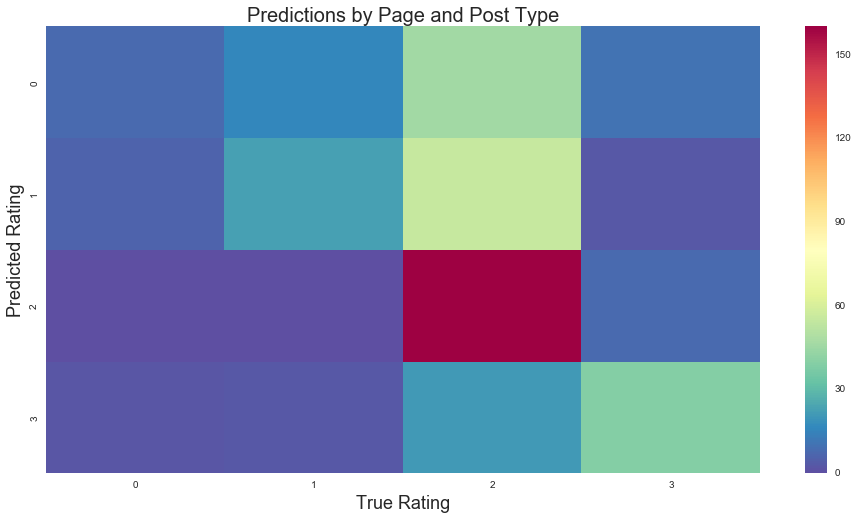

Overall Error Rate:  42.5 %


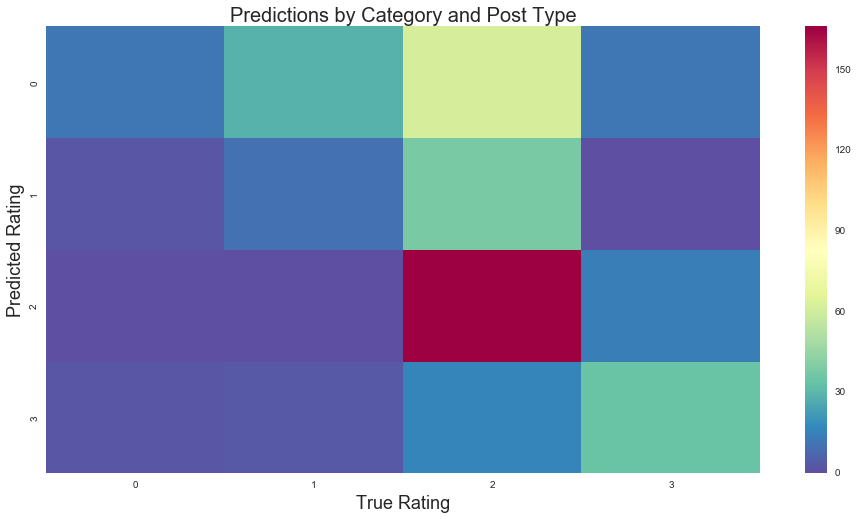

Overall Error Rate:  44.5 %


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


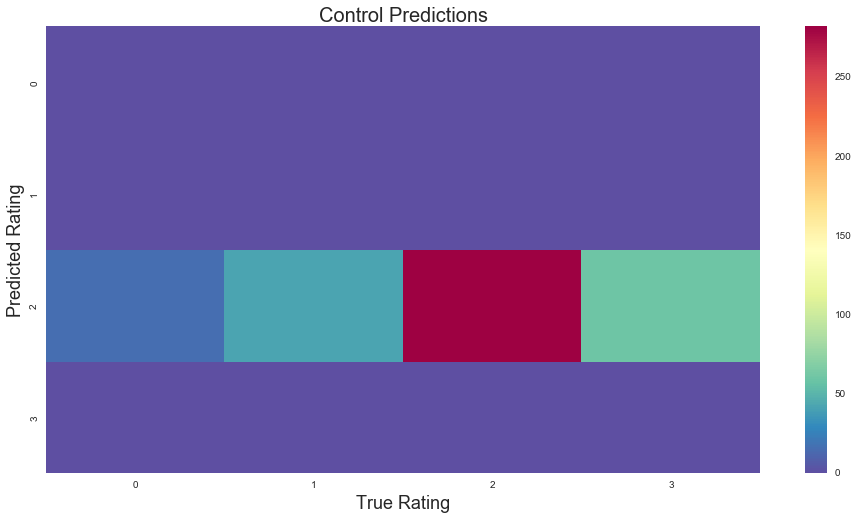

Overall Error Rate:  29.5 %
RMSE by Page
0.877496438739
RMSE by Category
0.953939201417
RMSE for Control (Assume All True)
0.644204936336


In [8]:
# Do the Naive Bayes classifier way, where you choose the argmax

page_predictions = np.argmax(predict_page_probs,axis=1)
cat_predictions = np.argmax(predict_cat_probs,axis=1)

conf_mat(page_predictions, true_vals, "Predictions by Page and Post Type", "page_predicts.png")
conf_mat(cat_predictions, true_vals, "Predictions by Category and Post Type", 'cat_predicts.png')
conf_mat(2*np.ones(n), true_vals, 'Control Predictions', 'control_predicts.png')

    
print "RMSE by Page"
print RMSE(page_predictions, true_vals)
print "RMSE by Category"
print RMSE(cat_predictions, true_vals)
print "RMSE for Control (Assume All True)"
print RMSE(2*np.ones(n), true_vals)

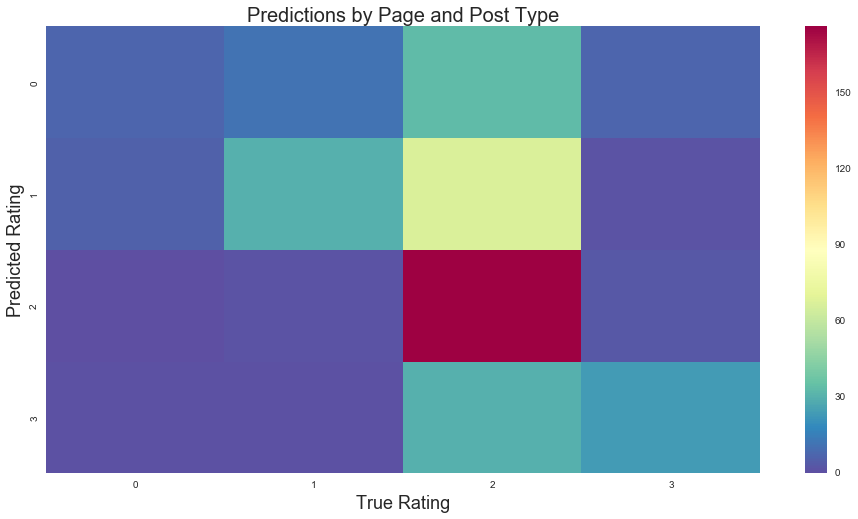

Overall Error Rate:  40.75 %


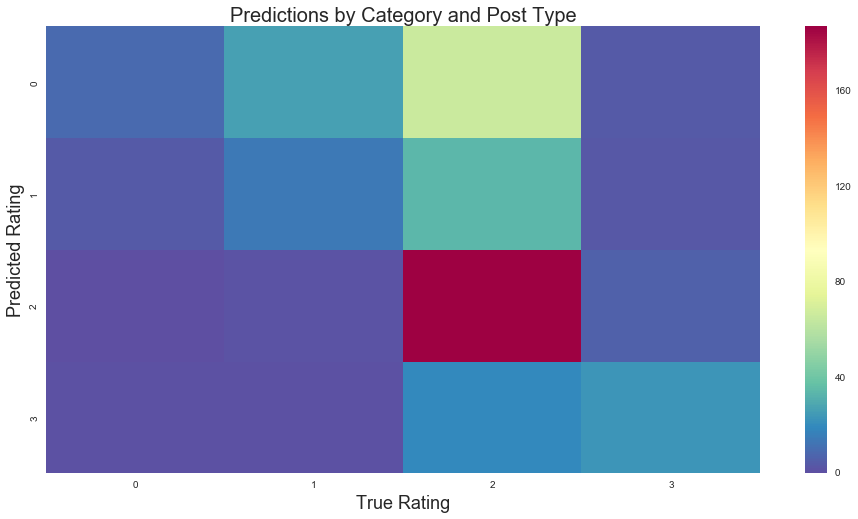

Overall Error Rate:  41.75 %


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:43: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


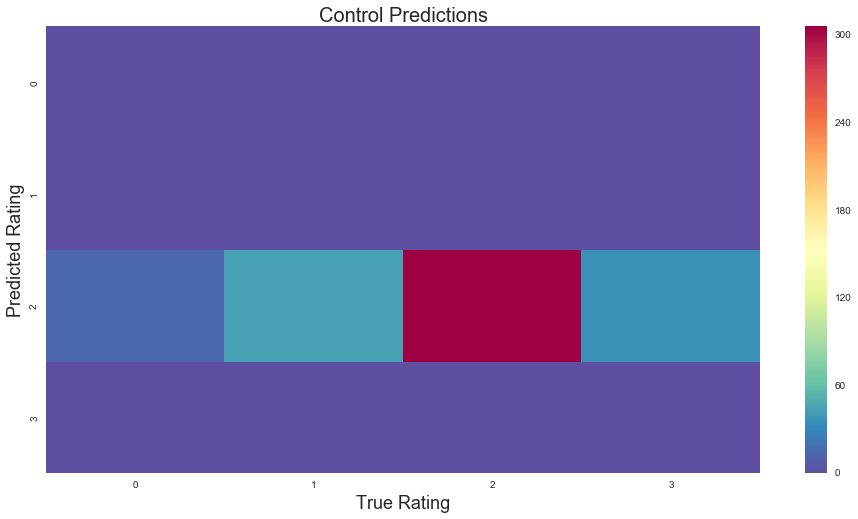

Overall Error Rate:  23.5 %
RMSE by Page
0.809320702812
RMSE by Category
0.955248658727
RMSE for Control (Assume All True)
0.583095189485


In [9]:
# Repeat classifier on train data to check overfitting

true_vals = np.array(train_data['Rating'])[:n]

# Get probability tables for Naive Bayes

page_probs, type_probs = build_probs(train_data, ['Page', 'Post Type'])
cat_probs, type_probs = build_probs(train_data, ['Category', 'Post Type'])

predict_page_probs = np.zeros((n,4))
predict_cat_probs = np.zeros((n,4))

# Estimate probability of each category for each test point
for i in xrange(n):
    test_pt = train_data.ix[all_inds[i+n]]
    
    for j in xrange(4):
        page_ind = test_pt['Page']
        cat_ind = test_pt['Category']
        type_ind = test_pt['Post Type']
        
        predict_page_probs[i,j] = page_probs[j,page_ind] * type_probs[j,type_ind]
        predict_cat_probs[i,j] = cat_probs[j,cat_ind] * type_probs[j,type_ind]
        
page_predictions = np.argmax(predict_page_probs,axis=1)
cat_predictions = np.argmax(predict_cat_probs,axis=1)

conf_mat(page_predictions, true_vals, "Predictions by Page and Post Type", "page_overfit.png")
conf_mat(cat_predictions, true_vals, "Predictions by Category and Post Type", 'cat_overfit.png')
conf_mat(2*np.ones(n), true_vals, 'Control Predictions', 'control_predicts.png')

    
print "RMSE by Page"
print RMSE(page_predictions, true_vals)
print "RMSE by Category"
print RMSE(cat_predictions, true_vals)
print "RMSE for Control (Assume All True)"
print RMSE(2*np.ones(n), true_vals)

In [37]:
# Test for overfitting- sensitivity and specificity

true_vals = np.array(train_data['Rating'])[:n]

# Get probability tables for Naive Bayes

page_probs, type_probs = build_probs(train_data, ['Page', 'Post Type'])
cat_probs, type_probs = build_probs(train_data, ['Category', 'Post Type'])

predict_page_probs = np.zeros((n,4))
predict_cat_probs = np.zeros((n,4))

# Estimate probability of each category for each test point
for i in xrange(n):
    test_pt = train_data.ix[all_inds[i+n]]
    
    for j in xrange(4):
        page_ind = test_pt['Page']
        cat_ind = test_pt['Category']
        type_ind = test_pt['Post Type']
        
        predict_page_probs[i,j] = page_probs[j,page_ind] * type_probs[j,type_ind]
        predict_cat_probs[i,j] = cat_probs[j,cat_ind] * type_probs[j,type_ind]
        
        # Sensitivity and specificity testing

print "Everything is True:"
print "\tSensitivity:", sensitivity(np.zeros(400), true_vals)
print "\tSpecificity:", specificity(np.zeros(400), true_vals)

print "\nEverything is False:"
print "\tSensitivity:", sensitivity(np.ones(400), true_vals)
print "\tSpecificity:", specificity(np.ones(400), true_vals)

print "\nFalse if 'mostly false' is highest probability:"
prediction = np.argmax(predict_cat_probs, axis=1)
prediction[prediction != 0] = 2
prediction[prediction == 0] = 1
prediction[prediction == 2] = 0
print "\tSensitivity:", sensitivity(prediction, true_vals)
print "\tSpecificity:", specificity(prediction, true_vals)

print "\nFalse if 'mostly false' or 'mixture' is highest probability:"
prediction = np.argmax(predict_cat_probs, axis=1)
prediction[prediction == 0] = 1
prediction[prediction == 0] = 1
prediction[prediction != 1] = 0
print "\tSensitivity:", sensitivity(prediction, true_vals)
print "\tSpecificity:", specificity(prediction, true_vals)

print "\nFalse if 'mostly false' is top two highest probability:"
toptwo = np.argsort(predict_cat_probs, axis=1)[:,2:]
prediction = np.zeros(n)
for i in xrange(n):
    if 0 in toptwo[i]:
        prediction[i] = 1
    else:
        prediction[i] = 0
print "\tSensitivity:", sensitivity(prediction, true_vals)
print "\tSpecificity:", specificity(prediction, true_vals)

for threshold in [0.75, 0.5, 0.15, 0.05, 0.01]:
    print "\nFalse if probability of 'mostly false' is > ", threshold
    
    prediction = np.zeros(n)
    for i in xrange(n):
        if predict_cat_probs[i,0] > threshold:
            prediction[i] = 1
        else:
            prediction[i] = 0
    print "\tSensitivity:", sensitivity(prediction, true_vals)
    print "\tSpecificity:", specificity(prediction, true_vals)
    
for threshold in [0.5, 0.25, 0.01]:
    print "\nFalse if normalized probability of 'mostly false' is > ", threshold
    
    prediction = np.zeros(n)
    for i in xrange(n):
        if predict_cat_probs[i,0]/np.sum(predict_cat_probs[i,:]) > threshold:
            prediction[i] = 1
        else:
            prediction[i] = 0
    print "\tSensitivity:", sensitivity(prediction, true_vals)
    print "\tSpecificity:", specificity(prediction, true_vals)

Everything is True:
	Sensitivity: 0.0
	Specificity: 1.0

Everything is False:
	Sensitivity: 1.0
	Specificity: 0.0

False if 'mostly false' is highest probability:
	Sensitivity: 0.642857142857
	Specificity: 0.748704663212

False if 'mostly false' or 'mixture' is highest probability:
	Sensitivity: 0.928571428571
	Specificity: 0.616580310881

False if 'mostly false' is top two highest probability:
	Sensitivity: 1.0
	Specificity: 0.549222797927

False if probability of 'mostly false' is >  0.75
	Sensitivity: 0.0
	Specificity: 1.0

False if probability of 'mostly false' is >  0.5
	Sensitivity: 0.642857142857
	Specificity: 0.748704663212

False if probability of 'mostly false' is >  0.15
	Sensitivity: 0.928571428571
	Specificity: 0.616580310881

False if probability of 'mostly false' is >  0.05
	Sensitivity: 0.928571428571
	Specificity: 0.593264248705

False if probability of 'mostly false' is >  0.01
	Sensitivity: 1.0
	Specificity: 0.549222797927

False if normalized probability of 'mostly 